# CS 598 DLH Final Project
## Conditional Graph Information Bottleneck for Molecular Relational Learning

## Introduction
With its extensive and complex datasets, the expanding field of molecular biology presents significant challenges for traditional computational analysis methods. Deep learning (DL) provides robust frameworks for managing these complexities, aiding progress in understanding molecular structures and their interactions. A notable contribution in this area is the "Conditional Graph Information Bottleneck for Molecular Relational Learning," which utilizes the principles of information bottleneck theory within graph neural networks (GNNs) for molecular data analysis [8, 9]. This method is a considerable advancement in computational biology, offering a sophisticated approach to extracting relevant information from molecular structures and their relational data.  

Molecular relational learning is a key challenge in computational biology, addressing the complex network of relationships and properties found in molecular data[12]. The authors of the study introduce a new architecture that effectively extracts and processes this molecular information, providing insights into molecular properties and interactions. Their work, based on deep learning and graph neural networks, not only shows how deep learning can improve our understanding of molecular systems but also sets a new benchmark for future studies in this area.

This project is motivated by the essential need to assess and understand the methodologies introduced in the paper[1]. By replicating the original study's experiments and examining additional applications of the proposed architecture, this project target to confirm the original findings and explore the model's applicability to various molecular datasets. The objective is to deepen our knowledge of how Deep Learning can be applied to understand molecular structures and their properties, thereby making a valuable contribution to the fields of computational biology and molecular research.  

The Conditional Graph Information Bottleneck (CGIB) approach introduces a new method for analyzing molecular data, balancing detailed analysis with the practical limits of computational resources[1]. This project builds upon this foundation, testing the CGIB model's robustness with different molecular datasets and applying it to new challenges within molecular biology. By thoroughly replicating and evaluating the original work, this project allows us gain a deep understanding of ongoing research on deep learning's potential to address the complexities of molecular science. 

## Scope of Reproducibility

In this section, we will validate the claims made by the CGIB paper through a series of experiments designed to test the framework's applicability and effectiveness across different molecular relational learning tasks. Specifically, we focus on the following experiments as outlined in the original work:
1. DrugDrugInteraction: This experiment investigates the potential of CGIB in predicting interactions between drug pairs, a crucial task in drug discovery and safety assessment.
2. MolecularInteraction: Here, the focus is on understanding the interactions between molecules, which is vital for applications in material science and chemical engineering.
3. SimilarityLearning: This task explores the framework's ability to learn and quantify the similarity between molecular structures, an essential aspect of computational chemistry for clustering, searching, and predicting molecular properties.


For each of these experiments, we will test the following hypotheses derived from the paper:
Hypothesis 1: CGIB can identify core subgraphs within molecular pairs that are crucial for predicting their interaction behavior, outperforming baseline methods that do not condition on the interaction partner.
Hypothesis 2: The performance improvements offered by CGIB are consistent across different molecular relational learning tasks, including but not limited to solubility prediction, reaction outcome prediction, and drug-drug interaction prediction.


To test these hypotheses, we will replicate the experiments conducted in the original paper, focusing on the following aspects:
1. Data: Utilize the same or a subset of the datasets used in the paper to ensure comparability.
2. Model Implementation: Reconstruct the CGIB model based on the descriptions and code provided in the paper.
3. Training: Follow the training procedures outlined in the paper, including computational requirements.
4. Evaluation: Apply the same metrics used in the paper to assess model performance.

Through this reproducibility study, we aim to assess the robustness and generalizability of the CGIB method, contributing to a deeper understanding of its strengths and limitations.

## DrugDrugInteraction

In [2]:
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from DrugDrugInteraction.data import build_dataset
from DrugDrugInteraction.utils import get_stats, write_summary, write_summary_total
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import Set2Set
from DrugDrugInteraction.embedder import embedder
from DrugDrugInteraction.layers import GINE
from DrugDrugInteraction.utils import create_batch_mask
from torch_scatter import scatter_mean, scatter_add, scatter_std


#### Data descriptions
Drug Drug Interaction uses dataset from [MIRACLE](https://github.com/isjakewong/MIRACLE/tree/main/MIRACLE/datachem) Multi-view Graph Contrastive Representation Learning for Drug-drug Interaction Prediction. This dataset contains 548 drugs and 48,548 pairwise DDI and multiple types of similarity information
about these drug pairs.

Example of the dataset
| drugbank_id_1	| drugbank_id_2 | smiles_2 | smiles_1 | cid_1 | cid_2 | label |
| --- | --- | --- | --- | --- | --- | --- |
| DB00492 | DB00252 | O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1 | CCC(=O)O[C@@H](O[P@](=O)(CCCCC1=CC=CC=C1)CC(=O)N1C[C@@H] (C[C@H]1C(O)=O)C1CCCCC1)C(C)C | CID000003419 | CID000001775 | 1 |
| DB00633 | DB01216 | [H][C@@]12CC[C@H](C(=O)NC(C)(C)C)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]2([H])NC(=O)C=C[C@]12C | C[C@H](C1=CNC=N1)C1=C(C)C(C)=CC=C1 | CID000060612 | CID000003350 | 0 |

First, we create three .pt files (train, valid, test) and save them in the "processed" folder. This might take a couple minutes

In [3]:
ddi_dataset = "ZhangDDI"  # ZhangDDI or ChChMiner

In [8]:
df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_train.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_train.pt")

df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_valid.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_valid.pt")

df = pd.read_csv(f'./DrugDrugInteraction/data/raw_data/{ddi_dataset}_test.csv', sep=",")
processed_data, dataset = build_dataset(df, "smiles_1", "smiles_2", "label")
torch.save(processed_data, f"./DrugDrugInteraction/data/processed/{ddi_dataset}_test.pt")

100%|███████████████████████████████████████████████████████████████████████████| 18727/18727 [00:56<00:00, 328.90it/s]


#### Define hyperparameters
The paper used 500 to 10000 epochs. We will be using 10 or less for this project due to time constraints.

In [4]:
lr = 0.001        # Learning rate for training the model
epochs = 10       # Number of epochs for training the model
beta = 1.0        # Hyperparameters for balance the trade-off between prediction and compression
tau = 1.0         # Temperature hyperparameter for CGIB_cont
device = 0        # gpu device

#### Load Dataset
This it might take around 20 seconds.

In [5]:
print("Loading dataset...")
start = time.time()

# Load dataset
train_set = torch.load("./DrugDrugInteraction/data/processed/{}_train.pt".format(ddi_dataset))
valid_set = torch.load("./DrugDrugInteraction/data/processed/{}_valid.pt".format(ddi_dataset)) 
test_set = torch.load("./DrugDrugInteraction/data/processed/{}_test.pt".format(ddi_dataset))

print("Dataset Loaded! ({:.4f} sec)".format(time.time() - start))

Loading dataset...
Dataset Loaded! (17.5887 sec)


## Methodology
### CGIB Model
#### Model Descriptions
A CIB-Graph is defined as the optimal graph discovered given a pair of graphs and its label information. 
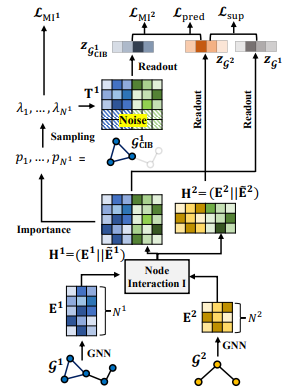

In [6]:
class CGIB(nn.Module):
    """
    This the main class for CIGIN model
    """

    def __init__(self,
                device,
                node_input_dim=133,
                edge_input_dim=14,
                node_hidden_dim=300,
                edge_hidden_dim=300,
                num_step_message_passing=3,
                interaction='dot',
                num_step_set2_set=2,
                num_layer_set2set=1,
                ):
        super(CGIB, self).__init__()

        self.device = device

        self.node_input_dim = node_input_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_input_dim = edge_input_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.num_step_message_passing = num_step_message_passing
        self.interaction = interaction

        self.gather = GINE(self.node_input_dim, self.edge_input_dim, 
                            self.node_hidden_dim, self.num_step_message_passing,
                            )

        self.predictor = nn.Linear(8 * self.node_hidden_dim, 1)

        self.compressor = nn.Sequential(
            nn.Linear(2 * self.node_hidden_dim, self.node_hidden_dim),
            nn.BatchNorm1d(self.node_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.node_hidden_dim, 1)
            )
        
        self.solvent_predictor = nn.Linear(4 * self.node_hidden_dim, 4 * self.node_hidden_dim)
        
        self.mse_loss = torch.nn.MSELoss()

        self.num_step_set2set = num_step_set2_set
        self.num_layer_set2set = num_layer_set2set
        self.set2set = Set2Set(2 * node_hidden_dim, self.num_step_set2set, self.num_layer_set2set)

        self.init_model()
    
    def init_model(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def compress(self, solute_features):
        
        p = self.compressor(solute_features)
        temperature = 1.0
        bias = 0.0 + 0.0001  # If bias is 0, we run into problems
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)
        gate_inputs = torch.log(eps) - torch.log(1 - eps)
        gate_inputs = gate_inputs.to(self.device)
        gate_inputs = (gate_inputs + p) / temperature
        gate_inputs = torch.sigmoid(gate_inputs).squeeze()

        return gate_inputs, p
    
    def forward(self, data, bottleneck = False, test = False):
        solute = data[0]
        solvent = data[1]
        solute_len = data[2]
        solvent_len = data[3]
        # node embeddings after interaction phase
        solute_features = self.gather(solute)
        solvent_features = self.gather(solvent)

        # Add normalization
        self.solute_features = F.normalize(solute_features, dim = 1)
        self.solvent_features = F.normalize(solvent_features, dim = 1)

        # Interaction phase
        len_map = torch.sparse.mm(solute_len.t(), solvent_len)

        interaction_map = torch.mm(self.solute_features, self.solvent_features.t())
        ret_interaction_map = torch.clone(interaction_map)
        ret_interaction_map = interaction_map * len_map.to_dense()
        interaction_map = interaction_map * len_map.to_dense()

        self.solvent_prime = torch.mm(interaction_map.t(), self.solute_features)
        self.solute_prime = torch.mm(interaction_map, self.solvent_features)

        # Prediction phase
        self.solute_features = torch.cat((self.solute_features, self.solute_prime), dim=1)
        self.solvent_features = torch.cat((self.solvent_features, self.solvent_prime), dim=1)

        if test:

            _, self.importance = self.compress(self.solute_features)
            self.importance = torch.sigmoid(self.importance)

        if bottleneck:

            lambda_pos, p = self.compress(self.solute_features)
            lambda_pos = lambda_pos.reshape(-1, 1)
            lambda_neg = 1 - lambda_pos

            # Get Stats
            preserve_rate = (torch.sigmoid(p) > 0.5).float().mean()

            static_solute_feature = self.solute_features.clone().detach()
            node_feature_mean = scatter_mean(static_solute_feature, solute.batch, dim = 0)[solute.batch]
            node_feature_std = scatter_std(static_solute_feature, solute.batch, dim = 0)[solute.batch]
            # node_feature_std, node_feature_mean = torch.std_mean(static_solute_feature, dim=0)
            
            noisy_node_feature_mean = lambda_pos * self.solute_features + lambda_neg * node_feature_mean
            noisy_node_feature_std = lambda_neg * node_feature_std

            noisy_node_feature = noisy_node_feature_mean + torch.rand_like(noisy_node_feature_mean) * noisy_node_feature_std
            noisy_solute_subgraphs = self.set2set(noisy_node_feature, solute.batch)

            epsilon = 1e-7

            KL_tensor = 0.5 * scatter_add(((noisy_node_feature_std ** 2) / (node_feature_std + epsilon) ** 2).mean(dim = 1), solute.batch).reshape(-1, 1) + \
                        scatter_add((((noisy_node_feature_mean - node_feature_mean)/(node_feature_std + epsilon)) ** 2), solute.batch, dim = 0)
            KL_Loss = torch.mean(KL_tensor)
            
            # Predict Solvent
            self.solvent_features_s2s = self.set2set(self.solvent_features, solvent.batch)
            solvent_pred_loss = self.mse_loss(self.solvent_features_s2s, self.solvent_predictor(noisy_solute_subgraphs))

            # Prediction Y
            final_features = torch.cat((noisy_solute_subgraphs, self.solvent_features_s2s), 1)
            predictions = self.predictor(final_features)

            return predictions, KL_Loss, solvent_pred_loss, preserve_rate
        
        else:

            self.solute_features_s2s = self.set2set(self.solute_features, solute.batch)
            self.solvent_features_s2s = self.set2set(self.solvent_features, solvent.batch)

            final_features = torch.cat((self.solute_features_s2s, self.solvent_features_s2s), 1)
            predictions = self.predictor(final_features)

            if test:
                return torch.sigmoid(predictions), ret_interaction_map

            else:
                return predictions, ret_interaction_map

In [9]:
class CGIB_ModelTrainer(embedder):
    def __init__(self, train_df, valid_df, test_df, repeat, fold):
        embedder.__init__(self, train_df, valid_df, test_df, repeat, fold)

        self.model = CGIB(device).to(device)
        self.optimizer = optim.Adam(params = self.model.parameters(), lr = lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', verbose=True)
        
    def train(self):        

        loss_function_BCE = nn.BCEWithLogitsLoss(reduction='none')

        for epoch in range(1, epochs + 1):
            self.model.train()
            self.train_loss = 0
            preserve = 0

            start = time.time()

            for bc, samples in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                masks = create_batch_mask(samples)
                
                outputs, _ = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)])
                loss = loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()

                # Information Bottleneck
                outputs, KL_Loss, solvent_pred_loss, preserve_rate = self.model([samples[0].to(self.device), samples[1].to(self.device), masks[0].to(self.device), masks[1].to(self.device)], bottleneck = True)
                loss += loss_function_BCE(outputs, samples[2].reshape(-1, 1).to(self.device).float()).mean()
                loss += beta * KL_Loss
                loss += beta * solvent_pred_loss

                loss.backward()
                self.optimizer.step()
                self.train_loss += loss
                preserve += preserve_rate
            
            self.epoch_time = time.time() - start

            self.model.eval()
            self.evaluate(epoch)

            self.scheduler.step(self.val_roc_score)

            # Write Statistics
            self.writer.add_scalar("stats/preservation", preserve/bc, epoch)

        self.evaluate(epoch, final = True)
        self.writer.close()
        
        return self.best_test_roc, self.best_test_ap, self.best_test_f1, self.best_test_acc

#### Training

In [ ]:
def summary(train_df, valid_df, test_df, repeat = 0, fold = 0):
    embedder = CGIB_ModelTrainer(train_df, valid_df, test_df, repeat, fold)
    best_roc, best_ap, best_f1, best_acc = embedder.train()

    return [best_roc, best_ap, best_f1, best_acc], embedder.config_str, embedder.best_config_roc, embedder.best_config_f1

best_rocs, best_aps, best_f1s, best_accs = [], [], [], []

stats, config_str, _, _ = summary(train_set, valid_set, test_set)

# get stats
best_rocs.append(stats[0])
best_aps.append(stats[1])
best_f1s.append(stats[2])
best_accs.append(stats[3])

write_summary(dataset, embedder, config_str, stats)


[Config] embedder_CGIB_lr_0.001_batch_size_512_dataset_ZhangDDI_beta_1.0

[Epoch: 1 (602.5114 sec)] Valid ROC: 0.5426 / AP: 0.3072 / F1: 0.4439 / Acc: 0.4327 || Test ROC: 0.5490 / AP: 0.2419 / F1: 0.3746 / Acc: 0.4078 
[Best ROC Epoch: 1] Best Valid ROC: 0.5426 / AP: 0.3072 || Best Test ROC: 0.5490 / AP: 0.2419 
[Best F1 Epoch: 1] Best Valid F1: 0.4439 / Acc: 0.4327 || Best Test F1: 0.3746 / Acc: 0.4078 


#### Evaluation

In [ ]:
roc_mean, roc_std = get_stats(best_rocs)
ap_mean, ap_std = get_stats(best_aps)
f1_mean, f1_std = get_stats(best_f1s)
accs_mean, accs_std = get_stats(best_accs)

write_summary_total(dataset, embedder, config_str, [roc_mean, roc_std, ap_mean, ap_std, f1_mean, f1_std, accs_mean, accs_std])

## Results

### Citations
<br> [1]  Bai, Y., Ding, H., Bian, S., Chen, T., Sun, Y., and Wang, W. Simgnn: A neural network approach to fast graph similarity computation. In Proceedings of the Twelfth ACM International Conference on Web Search and Data Mining, pp. 384–392, 2019. </br>
<br>[2]  Joung, J. F., Han, M., Hwang, J., Jeong, M., Choi, D. H., and Park, S. Deep learning optical spectroscopy based on experimental database: Potential applications to molecular design. JACS Au, 1(4):427–438, 2021. </br>
<br>[3]  Lim, H. and Jung, Y. Delfos: deep learning model for prediction of solvation free energies in generic organic solvents. Chemical science, 10(36):8306–8315, 2019 </br>
<br>[4]  Namkyeong Lee, Dongmin Hyun, Gyoung S. Na, Sungwon Kim, Junseok Lee, and Chanyoung Park. "Conditional Graph Information Bottleneck for Molecular Relational Learning." ICML 2023. </br>
<br>[5] Tishby, N., Pereira, F. C., and Bialek, W. The information bottleneck method. arXiv preprint physics/0004057, 2000.
<br>[6]  Wang, Y., Min, Y., Chen, X., and Wu, J. Multi-view graph contrastive representation learning for drug-drug interaction prediction. In Proceedings of the Web Conference 2021, pp. 2921–2933, 2021. </br>
<br>[7]  Xu, X., Liu, C., Feng, Q., Yin, H., Song, L., and Song, D. Neural network-based graph embedding for crossplatform binary code similarity detection. In Proceedings of the 2017 ACM SIGSAC Conference on Computer and Communications Security, pp. 363–376, 2017. </br>
<br>[8] Yu, J., Cao, J., and He, R. Improving subgraph recogni- tion with variational graph information bottleneck. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 19396–19405, 2022. </br>
<br>[9] Zhang, Z., Bu, J., Ester, M., Li, Z., Yao, C., Yu, Z., and Wang, C. H2mn: Graph similarity learning with hierar- chical hypergraph matching networks. In Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery & Data Mining, pp. 2274–2284, 2021. </br>
<br>[10] Zhang, W., Chen, Y., Liu, F., Luo, F., Tian, G., and Li, X. Predicting potential drug-drug interactions by integrating chemical, biological, phenotypic and network data. BMC bioinformatics, 18(1):1–12, 2017. </br>
<br>[11] Purser, S., Moore, P. R., Swallow, S., and Gouverneur, V. Fluorine in medicinal chemistry. Chemical Society Re- views, 37(2):320–330, 2008. </br>
<br>[12] Joung, J. F., Han, M., Hwang, J., Jeong, M., Choi, D. H., and Park, S. Deep learning optical spectroscopy based on ex- perimental database: Potential applications to molecular design. JACS Au, 1(4):427–438, 2021. </br>
<br>[13] Namkyeong Lee, Dongmin Hyun, Gyoung S. Na, Sungwon Kim, Junseok Lee, Chanyoung Park. Conditional Graph Information Bottleneck for Molecular Relational Learning, 2305.01520, 2023 </br>